# Correlations between records and SPG temperatures

In [1]:
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from IPython.display import Markdown as mdp
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import re
#import scipy.stats
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import sys
import xarray as xr
sys.path.append('../../lib')
from regimeshifts import ews

In [2]:
allrec_data = pd.read_csv('output/sel_records_data.csv',index_col=0)
allrec_md = pd.read_csv('output/sel_records_metadata.csv',index_col=0)

In [3]:
### EN4 dataset

start_year = 1900
#start_year = 1960

en4_file = '../../../datasets/EN4/EN.4.2.2.analyses.g10/*.nc'
en4 = xr.open_mfdataset(en4_file,combine='by_coords')
en4 = en4.sel(time=(en4.time.dt.year>=start_year),depth=slice(*[0,100]))
en4 = en4.assign_coords(lon=(((en4.lon + 180) % 360) - 180))
en4 = en4.sortby(en4.lon)
### Following the definition by Swingedouw
### We define SPG as the box 70°W–20°W, 45°N–60°N
en4_spg = en4.sel(lon =slice(*[-70,-15]), lat = slice(*[45,60])) ## 

## Averaging the first 100m
en4_avg_depth = en4_spg.temperature.mean(dim='depth').to_dataset()
en4_ann = en4_avg_depth.resample(time='A').mean()
en4_ann_spg = en4_ann.mean(dim=['lat','lon']).to_dataframe()
en4_ann_spg.index = en4_ann_spg.index.year

## North Atlantic
en4_na = en4.sel(lon =slice(*[-60,25]), lat = slice(*[45,72]))
en4_na_depth = en4_na.temperature.mean(dim='depth').to_dataset()
en4_na_ann = en4_na_depth.resample(time='A').mean().load()

/home/ra499/miniconda3/lib/python3.12/site-packages/xarray/core/groupby.py:508: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(
/home/ra499/miniconda3/lib/python3.12/site-packages/xarray/core/groupby.py:508: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


In [4]:
## Correlations with the SPG region
start_year = 1960
en4_ann_spg_1960 = en4_ann_spg[en4_ann_spg.index>=start_year]
sel_recs = allrec_data[[c for c in allrec_data.columns if c != 'FG_JEM_d13C']] ## Record with discontinuous data
sel_recs = sel_recs[sel_recs.index>=start_year]
corrs_spg_1960 = pd.DataFrame(index=sel_recs.columns,columns=['r_detr','r_detr_pv',
                                                             'r_detr_lag1','r_detr_lag1_pv',
                                                              'r_detr_lag2','r_detr_lag2_pv'])
bW = 35
en4_ann_spg_res = ews.Ews(en4_ann_spg_1960).gaussian_det(bW=bW).res.iloc[:, 0]
for rec_id in sel_recs.columns:
    ts_en4 = en4_ann_spg_1960[en4_ann_spg_1960.index<=sel_recs[rec_id].dropna().index.max()]
    ts_en4_res = en4_ann_spg_res[en4_ann_spg_res.index<=sel_recs[rec_id].dropna().index.max()]
    
    ## Detrending
    reci_detr = ews.Ews(sel_recs[rec_id]).gaussian_det(bW=bW).res.iloc[:, 0]
    pearson = stats.pearsonr(ts_en4_res.values, reci_detr.dropna().values)
    corrs_spg_1960.loc[rec_id,'r_detr'] = pearson[0]
    corrs_spg_1960.loc[rec_id,'r_detr_pv'] = pearson[1]
    ### SPG temperatures leading by 1 year
    reci_detr_lagged = reci_detr.copy(deep = True)
    reci_detr_lagged.index -= 1
    ###
    pearson = stats.pearsonr(ts_en4_res.drop(ts_en4_res.tail(1).index).values, 
                             reci_detr_lagged.drop(reci_detr_lagged.head(1).index).dropna().values)
    corrs_spg_1960.loc[rec_id,'r_detr_lag1'] = pearson[0]
    corrs_spg_1960.loc[rec_id,'r_detr_lag1_pv'] = pearson[1]
    ### SPG temperatures leading by 2 years
    reci_detr_lagged2 = reci_detr.copy(deep = True)
    reci_detr_lagged2.index -= 2
    ###
    pearson = stats.pearsonr(ts_en4_res.drop(ts_en4_res.tail(2).index).values, 
                             reci_detr_lagged2.drop(reci_detr_lagged2.head(2).index).dropna().values)
    corrs_spg_1960.loc[rec_id,'r_detr_lag2'] = pearson[0]
    corrs_spg_1960.loc[rec_id,'r_detr_lag2_pv'] = pearson[1]

for col in ['r_detr','r_detr_lag1','r_detr_lag2']:
    corrs_spg_1960[col] = pd.to_numeric(corrs_spg_1960[col])
r_values = corrs_spg_1960[['r_detr','r_detr_lag1','r_detr_lag2']]
corrs_spg_1960['Max_name'] = r_values.abs().idxmax(axis=1)
for rec_id in corrs_spg_1960.index:
    max_name = corrs_spg_1960.loc[rec_id,'Max_name']
    rmax = corrs_spg_1960.loc[rec_id,max_name]
    pvmax = corrs_spg_1960.loc[rec_id,max_name+'_pv']
    lag = 1 if '1' in max_name else (2 if '2' in max_name else 0)
    corrs_spg_1960.loc[rec_id,'r_max'] = rmax
    corrs_spg_1960.loc[rec_id,'pv_max'] = pvmax
    corrs_spg_1960.loc[rec_id,'lag_max'] = int(lag)
    
corrs_spg_1960.to_csv('output/corrs_biv_en4temp_spg.csv')

In [5]:
ews_recent = pd.read_csv('output/pvalues_coords_since_1920.csv',index_col=0)
corrsSPG_recent = corrs_spg_1960.loc[ews_recent.index]
#ews_recent['corrSPG_max'] = corrsSPG_recent.r_max.abs()
corrsSPG_recent['median_ar1'] = ews_recent['median']
lambda_stats = pd.read_csv('output/rob_statistics_lambda_1920_today.csv',index_col=0)
corrsSPG_recent['median_lambda'] = lambda_stats['median']

In [6]:
## Correlations with the local temperatures
start_year = 1960

sel_recs = allrec_data[[c for c in allrec_data.columns if c != 'FG_JEM_d13C']]
sel_recs = sel_recs[sel_recs.index>=start_year]
corrs_na_1960 = pd.DataFrame(index=sel_recs.columns,columns=['r_detr','r_detr_pv',
                                                             'r_detr_lag1','r_detr_lag1_pv',
                                                             'r_detr_lag2','r_detr_lag2_pv',#)
                                                             'r','r_pv'])
bW = 35
for rec_id in sel_recs.columns:
    lat = (allrec_md.loc[rec_id]['Northernmost_lat']+allrec_md.loc[rec_id]['Southernmost_lat'])/2
    lon = (allrec_md.loc[rec_id]['Westernmost_lon']+allrec_md.loc[rec_id]['Easternmost_lon'])/2
    temp_ts = en4_na_ann.sel(lat=lat,lon=lon,method='nearest').drop_vars(['lat','lon']).to_dataframe()
    temp_ts.index = temp_ts.index.year
    temp_ts_1960 = temp_ts[(temp_ts.index>=start_year)& (temp_ts.index<=sel_recs[rec_id].dropna().index.max())]
    temp_ts_1960 = temp_ts_1960['temperature']
    temp_en4_res = ews.Ews(temp_ts_1960).gaussian_det(bW=bW).res.iloc[:, 0]
    ### Without detrending
    pearson = stats.pearsonr(temp_ts_1960.values, sel_recs[rec_id].dropna().values)
    corrs_na_1960.loc[rec_id,'r'] = pearson[0]
    corrs_na_1960.loc[rec_id,'r_pv'] = pearson[1]    
    ## Detrending
    reci_detr = ews.Ews(sel_recs[rec_id]).gaussian_det(bW=bW).res.iloc[:, 0]
    pearson = stats.pearsonr(temp_en4_res.values, reci_detr.dropna().values)
    corrs_na_1960.loc[rec_id,'r_detr'] = pearson[0]
    corrs_na_1960.loc[rec_id,'r_detr_pv'] = pearson[1]
    ### Temperatures leading by 1 year
    reci_detr_lagged = reci_detr.copy(deep = True)
    reci_detr_lagged.index -= 1
    ###
    pearson = stats.pearsonr(temp_en4_res.drop(temp_en4_res.tail(1).index).values, 
                             reci_detr_lagged.drop(reci_detr_lagged.head(1).index).dropna().values)
    corrs_na_1960.loc[rec_id,'r_detr_lag1'] = pearson[0]
    corrs_na_1960.loc[rec_id,'r_detr_lag1_pv'] = pearson[1]
    ### Temperatures leading by 2 years
    reci_detr_lagged2 = reci_detr.copy(deep = True)
    reci_detr_lagged2.index -= 2
    ###
    pearson = stats.pearsonr(temp_en4_res.drop(temp_en4_res.tail(2).index).values, 
                             reci_detr_lagged2.drop(reci_detr_lagged2.head(2).index).dropna().values)
    corrs_na_1960.loc[rec_id,'r_detr_lag2'] = pearson[0]
    corrs_na_1960.loc[rec_id,'r_detr_lag2_pv'] = pearson[1]
for col in ['r_detr','r_detr_lag1','r_detr_lag2','r']:
    corrs_na_1960[col] = pd.to_numeric(corrs_na_1960[col])
corrsTemp_recent = corrs_na_1960.loc[ews_recent.index]
corrsTemp_recent['median_ar1'] = ews_recent['median']
corrsTemp_recent['median_lambda'] = lambda_stats['median']

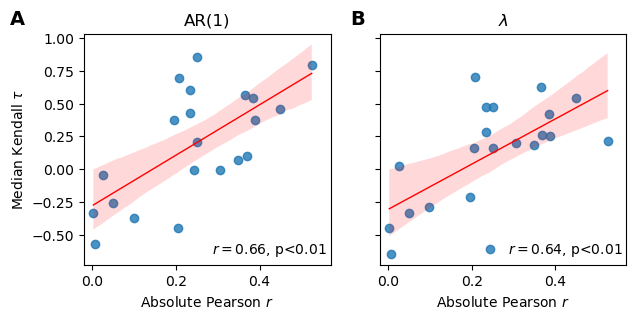

In [7]:
### Plotting the relationship between Correlations with the SPG and the median AR(1) and lambda trends.
### The linear fit is plotted along with the 95% confidence interval for the fit. 
plt.close()
fig, axs = plt.subplots(1,2,figsize=(7,3),facecolor='white',sharey=True)
strings = ['r_detr'];

sns.regplot(x=corrsSPG_recent[strings[0]].abs(), y=corrsSPG_recent['median_ar1'],ax=axs[0],line_kws=dict(color="r",linewidth=1))
corrs = stats.pearsonr(corrsSPG_recent[strings[0]].abs(), 
                         ews_recent['median'])
pval = '<0.01'if corrs[1] < 0.01 else f'={corrs[1]:.2f}'
axs[0].text(x=0.52,y=0.05,s=fr'$r=${corrs[0]:.2f}, p{pval}',transform=axs[0].transAxes,fontsize=10)

## Lambda
sns.regplot(x=corrsSPG_recent[strings[0]].abs().astype(float), y=corrsSPG_recent['median_lambda'],ax=axs[1],line_kws=dict(color="r",linewidth=1))
corrs = stats.pearsonr(corrsSPG_recent[strings[0]].abs(), 
                         corrsSPG_recent['median_lambda'])
pval = '<0.01'if corrs[1] < 0.01 else f'={corrs[1]:.2f}'
axs[1].text(x=0.52,y=0.05,s=fr'$r=${corrs[0]:.2f}, p{pval}',transform=axs[1].transAxes,fontsize=10)

for ax in axs:
    ax.set_ylabel('')
    ax.set_xlim(-0.02,0.57)
    ax.set_xlabel(r'Absolute Pearson $r$')
axs[0].set_ylabel(r'Median Kendall $\tau$ ');
axs[0].set_title(f'AR(1)')
axs[1].set_title(r'$\lambda$')
axs[0].text(x=-0.3,y=1.04,s='A',transform=axs[0].transAxes,fontsize=14,fontweight='bold')
axs[1].text(x=-0.12,y=1.04,s='B',transform=axs[1].transAxes,fontsize=14,fontweight='bold');
plt.show()
fig.savefig(f'img/Corrs_AR1_lambda_trends_SPG_EN4_temp.pdf',dpi=500, bbox_inches='tight')

In [8]:
amv_monthly = pd.read_csv('data/amon.us.long.data', sep=r'\s+',header=None,index_col=0,names=np.arange(1,13))
amv_monthly = amv_monthly.stack().reset_index().rename(columns={'level_0':'year','level_1':'month',0:'AMV'})
amv_monthly['date'] = pd.to_datetime([f'{y}-{m}-16' for y, m in zip(amv_monthly.year, amv_monthly.month)])
amv_monthly.index = amv_monthly.date
amv_monthly = amv_monthly['AMV']
amv_monthly.replace(-99.990, np.nan, inplace=True)
amv_annual = amv_monthly.resample('YE').mean()

In [9]:
### Correlations with the AMV index
start_year = 1960
amv_annual_trimmed = amv_annual[amv_annual.index.year>=start_year]
sel_recs = allrec_data[[c for c in allrec_data.columns if c != 'FG_JEM_d13C']]
sel_recs = sel_recs[sel_recs.index>=start_year]
corrs_amv = pd.DataFrame(index=sel_recs.columns,columns=['r_detr','r_detr_pv',
                                                        'r_lag1','r_lag1_pv',
                                                        'r_lag2','r_lag2_pv',
                                                        'r','r_pv'])

bW = 35
for rec_id in sel_recs.columns:
    ts_amv = amv_annual_trimmed[amv_annual_trimmed.index.year<=sel_recs[rec_id].dropna().index.max()]    
    ### Without detrending
    pearson = stats.pearsonr(ts_amv.values, sel_recs[rec_id].dropna().values)
    corrs_amv.loc[rec_id,'r'] = pearson[0]
    corrs_amv.loc[rec_id,'r_pv'] = pearson[1]    
    
    ## Detrending bivalve records
    reci_detr = ews.Ews(sel_recs[rec_id]).gaussian_det(bW=bW).res.iloc[:, 0]
    pearson = stats.pearsonr(ts_amv.values, reci_detr.dropna().values)
    corrs_amv.loc[rec_id,'r_detr'] = pearson[0]
    corrs_amv.loc[rec_id,'r_detr_pv'] = pearson[1]
    ### NAO leading by 1 year
    reci_lagged = sel_recs[rec_id].copy(deep = True)
    reci_lagged.index -= 1
    ###
    pearson = stats.pearsonr(ts_amv.drop(ts_amv.tail(1).index).values, 
                             reci_lagged.drop(reci_lagged.head(1).index).dropna().values)
    corrs_amv.loc[rec_id,'r_lag1'] = pearson[0]
    corrs_amv.loc[rec_id,'r_lag1_pv'] = pearson[1]
    ### NAO leading by 2 years
    reci_lagged2 = sel_recs[rec_id].copy(deep = True)
    reci_lagged2.index -= 2
    ###
    pearson = stats.pearsonr(ts_amv.drop(ts_amv.tail(2).index).values, 
                             reci_lagged2.drop(reci_lagged2.head(2).index).dropna().values)
    corrs_amv.loc[rec_id,'r_lag2'] = pearson[0]
    corrs_amv.loc[rec_id,'r_lag2_pv'] = pearson[1]
for col in ['r_detr','r_lag1','r_lag2','r']:
    corrs_amv[col] = pd.to_numeric(corrs_amv[col])

ews_recent = pd.read_csv('output/pvalues_coords_since_1920.csv',index_col=0)
corrsAMV_recent = corrs_amv.loc[ews_recent.index]
#ews_recent['corrSPG_max'] = corrsSPG_recent.r_max.abs()
corrsAMV_recent['median_ar1'] = ews_recent['median']
lambda_stats = pd.read_csv('output/rob_statistics_lambda_1920_today.csv',index_col=0)
corrsAMV_recent['median_lambda'] = lambda_stats['median']

In [10]:
## NAO Data
nao_monthly = pd.read_csv('data/norm_nao_monthly.ascii', sep=r'\s+',names=['year','month','NAO'])
nao_monthly['date'] = pd.to_datetime(dict(year=nao_monthly.year, month=nao_monthly.month, day=16))
nao_monthly.index = nao_monthly.date
nao_monthly = nao_monthly['NAO']
nao_annual = nao_monthly.resample('YE').mean()
nao_monthly = nao_monthly.to_frame()

In [11]:
nao_station = pd.read_csv('data/nao_station_monthly.txt', sep=r'\s+',skiprows=1)
nao_station = nao_station.stack().reset_index().rename(columns={'level_0':'year','level_1':'month',0:'NAO'})
nao_station['date'] = pd.to_datetime([f'{y}-{m}-16' for y, m in zip(nao_station.year, nao_station.month)])
nao_station.index = nao_station.date
nao_station = nao_station['NAO']
nao_station.replace(-999.0, np.nan, inplace=True)
nao_station_annual = nao_station.resample('YE').mean()

In [12]:
nao_winter_station = pd.read_csv('data/nao_station_djfm.txt', sep=r'\s+',skiprows=1,names=['year','winterNAO'])
nao_winter_station.index = pd.to_datetime(nao_winter_station.year,format='%Y')
nao_winter_station = nao_winter_station['winterNAO']
nao_winter_station.replace(-999.0, np.nan, inplace=True)

In [13]:
### Correlations with the NAO index
start_year = 1960
nao_annual_1960 = nao_annual[nao_annual.index.year>=start_year]
sel_recs = allrec_data[[c for c in allrec_data.columns if c != 'FG_JEM_d13C']]
sel_recs = sel_recs[sel_recs.index>=start_year]
corrs_nao_1960 = pd.DataFrame(index=sel_recs.columns,columns=['r_detr','r_detr_pv',
                                                             'r_lag1','r_lag1_pv',
                                                              'r_lag2','r_lag2_pv',
                                                              'r','r_pv'])

bW = 35
for rec_id in sel_recs.columns:
    ts_nao = nao_annual_1960[nao_annual_1960.index.year<=sel_recs[rec_id].dropna().index.max()]
    ### Without detrending
    pearson = stats.pearsonr(ts_nao.values, sel_recs[rec_id].dropna().values)
    corrs_nao_1960.loc[rec_id,'r'] = pearson[0]
    corrs_nao_1960.loc[rec_id,'r_pv'] = pearson[1]    
    
    ## Detrending bivalve records
    reci_detr = ews.Ews(sel_recs[rec_id]).gaussian_det(bW=bW).res.iloc[:, 0]
    pearson = stats.pearsonr(ts_nao.values, reci_detr.dropna().values)
    corrs_nao_1960.loc[rec_id,'r_detr'] = pearson[0]
    corrs_nao_1960.loc[rec_id,'r_detr_pv'] = pearson[1]
    ### NAO leading by 1 year
    reci_lagged = sel_recs[rec_id].copy(deep = True)
    reci_lagged.index -= 1
    ###
    pearson = stats.pearsonr(ts_nao.drop(ts_nao.tail(1).index).values, 
                             reci_lagged.drop(reci_lagged.head(1).index).dropna().values)
    corrs_nao_1960.loc[rec_id,'r_lag1'] = pearson[0]
    corrs_nao_1960.loc[rec_id,'r_lag1_pv'] = pearson[1]
    ### NAO leading by 2 years
    reci_lagged2 = sel_recs[rec_id].copy(deep = True)
    reci_lagged2.index -= 2
    ###
    pearson = stats.pearsonr(ts_nao.drop(ts_nao.tail(2).index).values, 
                             reci_lagged2.drop(reci_lagged2.head(2).index).dropna().values)
    corrs_nao_1960.loc[rec_id,'r_lag2'] = pearson[0]
    corrs_nao_1960.loc[rec_id,'r_lag2_pv'] = pearson[1]
for col in ['r_detr','r_lag1','r_lag2']:
    corrs_nao_1960[col] = pd.to_numeric(corrs_nao_1960[col])
ews_recent = pd.read_csv('output/pvalues_coords_since_1920.csv',index_col=0)
corrsNAO_recent = corrs_nao_1960.loc[ews_recent.index]
#ews_recent['corrSPG_max'] = corrsSPG_recent.r_max.abs()
corrsNAO_recent['median_ar1'] = ews_recent['median']
lambda_stats = pd.read_csv('output/rob_statistics_lambda_1920_today.csv',index_col=0)
corrsNAO_recent['median_lambda'] = lambda_stats['median']

In [14]:
nao_winter = nao_monthly[nao_monthly.index.month.isin([12,1,2])] #[12,1,2,3]
nao_winter_offset = nao_winter.copy()
nao_winter_offset.index = nao_winter.index + pd.DateOffset(months=1)
nao_winter_avg = nao_winter_offset.resample('YE').mean()
nao_winter_avg = nao_winter_avg['NAO']

In [15]:
## NAO winter index
start_year = 1960
nao_winter_trimmed = nao_winter_avg[nao_winter_avg.index.year>=start_year]
sel_recs = allrec_data[[c for c in allrec_data.columns if c != 'FG_JEM_d13C']]
sel_recs = sel_recs[sel_recs.index>=start_year]
corrs_nao_winter = pd.DataFrame(index=sel_recs.columns,columns=['r_detr','r_detr_pv',
                                                                'r_lag1','r_lag1_pv',
                                                                'r_lag2','r_lag2_pv',
                                                                'r','r_pv'])

bW = 35
for rec_id in sel_recs.columns:
    ts_nao = nao_winter_trimmed[nao_winter_trimmed.index.year<=sel_recs[rec_id].dropna().index.max()]
    ### Without detrending
    pearson = stats.pearsonr(ts_nao.values, sel_recs[rec_id].dropna().values)
    corrs_nao_winter.loc[rec_id,'r'] = pearson[0]
    corrs_nao_winter.loc[rec_id,'r_pv'] = pearson[1] 
    
    ## Detrending bivalve records
    reci_detr = ews.Ews(sel_recs[rec_id]).gaussian_det(bW=bW).res.iloc[:, 0]
    pearson = stats.pearsonr(ts_nao.values, reci_detr.dropna().values)
    corrs_nao_winter.loc[rec_id,'r_detr'] = pearson[0]
    corrs_nao_winter.loc[rec_id,'r_detr_pv'] = pearson[1]
    ### NAO leading by 1 year
    reci_lagged = sel_recs[rec_id].copy(deep = True)
    reci_lagged.index -= 1
    ###
    pearson = stats.pearsonr(ts_nao.drop(ts_nao.tail(1).index).values, 
                             reci_lagged.drop(reci_lagged.head(1).index).dropna().values)
    corrs_nao_winter.loc[rec_id,'r_lag1'] = pearson[0]
    corrs_nao_winter.loc[rec_id,'r_lag1_pv'] = pearson[1]
    ### NAO leading by 2 years
    reci_lagged2 = sel_recs[rec_id].copy(deep = True)
    reci_lagged2.index -= 2
    ###
    pearson = stats.pearsonr(ts_nao.drop(ts_nao.tail(2).index).values, 
                             reci_lagged2.drop(reci_lagged2.head(2).index).dropna().values)
    corrs_nao_winter.loc[rec_id,'r_lag2'] = pearson[0]
    corrs_nao_winter.loc[rec_id,'r_lag2_pv'] = pearson[1]
for col in ['r_detr','r_lag1','r_lag2']:
    corrs_nao_winter[col] = pd.to_numeric(corrs_nao_winter[col])

###
ews_recent = pd.read_csv('output/pvalues_coords_since_1920.csv',index_col=0)
corrsNAOwint_recent = corrs_nao_winter.loc[ews_recent.index]
#ews_recent['corrSPG_max'] = corrsSPG_recent.r_max.abs()
corrsNAOwint_recent['median_ar1'] = ews_recent['median']
corrsNAOwint_recent['median_lambda'] = lambda_stats['median']

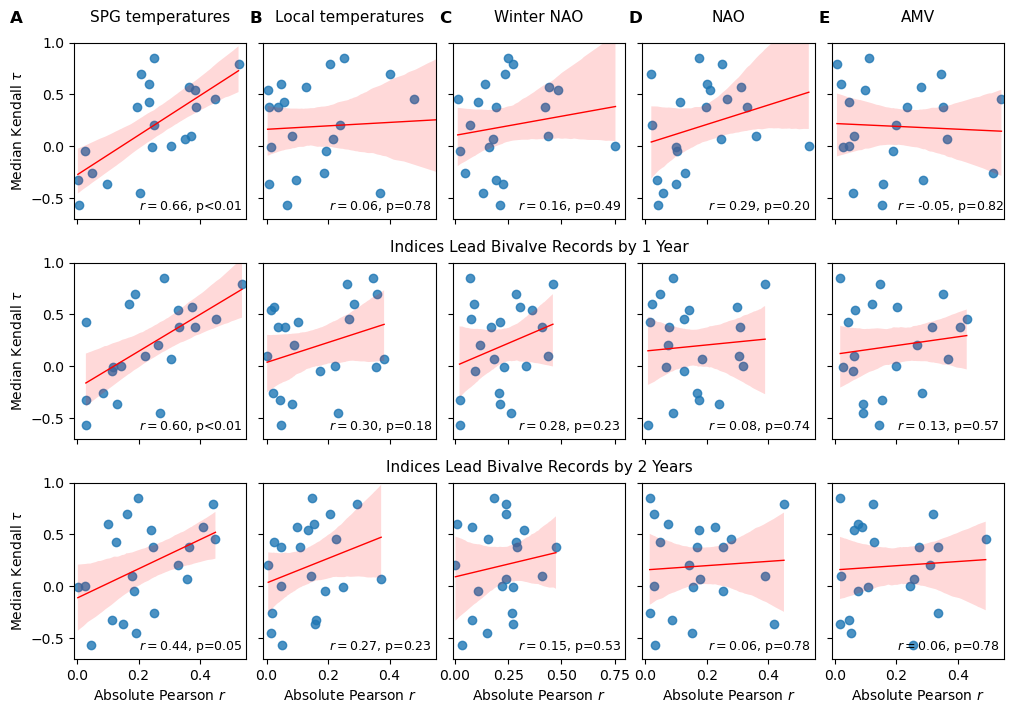

In [16]:
### Plotting the relationship between Correlations with the SPG and the median AR(1) and lambda trends.
### The linear fit is plotted along with the 95% confidence interval for the fit. 
plt.close()
fig, axs = plt.subplots(3,5,figsize=(12,8),facecolor='white',sharey='row',sharex='col',gridspec_kw={'wspace': 0.1,'hspace': 0.25})

for i in [0,1,2]:

    typecorr = f'r_detr_lag{i}' if i>0 else 'r_detr'

    sns.regplot(x=corrsSPG_recent[typecorr].abs(), y=corrsSPG_recent['median_ar1'],ax=axs[i,0],line_kws=dict(color="r",linewidth=1))
    corrs = stats.pearsonr(corrsSPG_recent[typecorr].abs(), 
                             ews_recent['median'])
    pval = '<0.01'if corrs[1] < 0.01 else f'={corrs[1]:.2f}'
    axs[i,0].text(x=0.38,y=0.05,s=fr'$r=${corrs[0]:.2f}, p{pval}',transform=axs[i,0].transAxes,fontsize=9)

    
    sns.regplot(x=corrsTemp_recent[typecorr].abs(), y=corrsTemp_recent['median_ar1'],ax=axs[i,1],line_kws=dict(color="r",linewidth=1))
    corrs = stats.pearsonr(corrsTemp_recent[typecorr].abs(), 
                             corrsTemp_recent['median_ar1'])
    pval = '<0.01'if corrs[1] < 0.01 else f'={corrs[1]:.2f}'
    axs[i,1].text(x=0.38,y=0.05,s=fr'$r=${corrs[0]:.2f}, p{pval}',transform=axs[i,1].transAxes,fontsize=9)

    typecorr = f'r_lag{i}' if i>0 else 'r'
    
    ## NAO winter
    sns.regplot(x=corrsNAOwint_recent[typecorr].abs().astype(float), y=corrsNAOwint_recent['median_ar1'],ax=axs[i,2],line_kws=dict(color="r",linewidth=1))
    corrs = stats.pearsonr(corrsNAOwint_recent[typecorr].abs(), 
                             corrsNAOwint_recent['median_ar1'])
    pval = '<0.01'if corrs[1] < 0.01 else f'={corrs[1]:.2f}'
    axs[i,2].text(x=0.38,y=0.05,s=fr'$r=${corrs[0]:.2f}, p{pval}',transform=axs[i,2].transAxes,fontsize=9)
    
    ## NAO annual
    sns.regplot(x=corrsNAO_recent[typecorr].abs().astype(float), y=corrsNAO_recent['median_ar1'],ax=axs[i,3],line_kws=dict(color="r",linewidth=1))
    corrs = stats.pearsonr(corrsNAO_recent[typecorr].abs(), 
                             corrsNAO_recent['median_ar1'])
    pval = '<0.01'if corrs[1] < 0.01 else f'={corrs[1]:.2f}'
    axs[i,3].text(x=0.38,y=0.05,s=fr'$r=${corrs[0]:.2f}, p{pval}',transform=axs[i,3].transAxes,fontsize=9)
    
    ## AMV
    sns.regplot(x=corrsAMV_recent[typecorr].abs().astype(float), y=corrsAMV_recent['median_ar1'],ax=axs[i,4],line_kws=dict(color="r",linewidth=1))
    corrs = stats.pearsonr(corrsAMV_recent[typecorr].abs(), 
                             corrsAMV_recent['median_ar1'])
    pval = '<0.01'if corrs[1] < 0.01 else f'={corrs[1]:.2f}'
    axs[i,4].text(x=0.38,y=0.05,s=fr'$r=${corrs[0]:.2f}, p{pval}',transform=axs[i,4].transAxes,fontsize=9)

for axes in axs:
    for ax in axes:
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_ylim(-0.7,1)
        ax.set_xlim(-0.01,0.55)
axs[2,2].set_xlim(-0.01,0.8)
for j in range(5):
    axs[2,j].set_xlabel(r'Absolute Pearson $r$')
axs[0,0].set_ylabel(r'Median Kendall $\tau$');
axs[1,0].set_ylabel(r'Median Kendall $\tau$ ');
axs[2,0].set_ylabel(r'Median Kendall $\tau$ ');
axs[0,0].set_title('SPG temperatures',fontsize=11,pad = 15)
axs[0,1].set_title('Local temperatures',fontsize=11,pad = 15)
axs[0,2].set_title(r'Winter NAO',fontsize=11,pad = 15)
axs[0,3].set_title(r'NAO',fontsize=11,pad = 15)
axs[0,4].set_title(r'AMV',fontsize=11,pad = 15)
letters = ['A','B','C','D','E']
for i in range(5):
    padx = -0.37 if i==0 else -0.08
    axs[0,i].text(x=padx,y=1.11,s=letters[i],transform=axs[0,i].transAxes,fontsize=12,fontweight='bold')

axs[1,2].text(x=0.5,y=1.06,s='Indices Lead Bivalve Records by 1 Year',transform=axs[1,2].transAxes,fontsize=11,horizontalalignment='center')
axs[2,2].text(x=0.5,y=1.06,s='Indices Lead Bivalve Records by 2 Years',transform=axs[2,2].transAxes,fontsize=11,horizontalalignment='center')

plt.show()
fig.savefig(f'img/Corrs_AR1_trends_all_lags.png',dpi=350, bbox_inches='tight')

### Comparison with SPG strength indices

In [17]:
spg_index_chaf = pd.read_csv('data/spg_chafik-2019-3.csv',header=None,names=['year','month','spgi'])
spg_index_chaf = spg_index_chaf.groupby('year').mean()['spgi']
ts_en4_spg = en4_ann_spg_1960[(en4_ann_spg_1960.index>=1993)&(en4_ann_spg_1960.index<=2018)]['temperature']
pearson_chaf = stats.pearsonr(ts_en4_spg.values, spg_index_chaf.values)

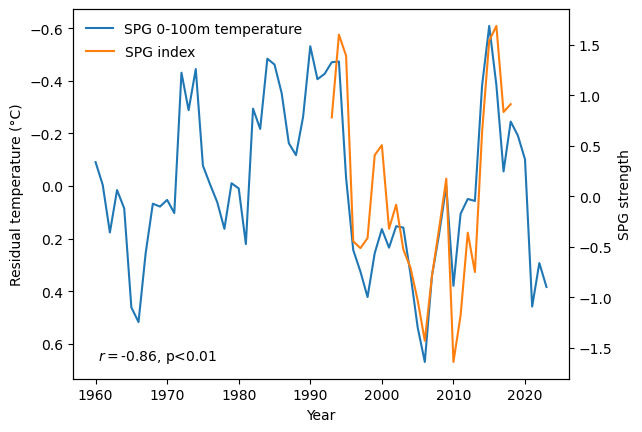

In [18]:
plt.close()
fig,axs = plt.subplots()
#en4_ann_spg_1960.plot(ax=axs)
en4_ann_spg_res.plot(ax=axs,label='SPG 0-100m temperature')
axs.invert_yaxis()
ax2 = axs.twinx()
#spg_index_comm.plot(ax=ax2,color='tab:green')
spg_index_chaf.plot(ax=ax2,color='tab:orange',label='SPG index')
#axs.set_ylim(0.8,-1)
#ax2.set_ylim(-1.7,2.4)
pval = '<0.01'if pearson_chaf[1] < 0.01 else f'={pearson_chaf[1]:.2f}'
axs.text(x=0.05,y=0.05,s=fr'$r=${pearson_chaf[0]:.2f}, p{pval}',transform=axs.transAxes,fontsize=10)
axs.legend(frameon=False,loc=2)
ax2.legend(frameon=False,loc=(0.015,0.85))
axs.set_ylabel('Residual temperature (°C)')
ax2.set_ylabel('SPG strength')
axs.set_xlabel('Year')
#fig.savefig(f'img/Corrs_SPG_EN4_SPG_index.png',dpi=300, bbox_inches='tight')
plt.show()